In [1]:
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy
from scvi_colab import install
install()
run_outside_colab=True
import scvi
import scipy.sparse
import decoupler as dc
import torch
import gzip
from gtfparse import read_gtf
from pybiomart import Dataset,Server

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
import os

/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
[rank: 0] Global seed set to 0


Last run with scvi-tools version: 1.0.4


In [2]:
############## Read in GENCODE for protein coding genes ################
gencode=read_gtf("../../gencode.v44.annotation.gtf")
protein_coding_genes = list(gencode.gene_name[np.where((gencode.feature=='gene')
            &(gencode.gene_type=='protein_coding')
            )[0]])


INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


In [3]:
inh = sc.read('../../HIV_data/single_cell_scorch/inh_v2_updated.h5ad')
inh
#inh.var_names=inh.var_names.str.upper()
#inh.var['gene_ids'] = inh.var_names
#inh.var=inh.var.reset_index(drop=True)
#inh.var_names= inh.var.gene_ids
#inh_upd = sc.read('../../SCORCH_HIV_data/inh_updated.h5ad')

AnnData object with n_obs × n_vars = 61946 × 40563
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'doublet'
    var: 'gene_ids', 'n_cells'
    uns: 'X_name', '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'subclass_colors', 'subtype_colors', 'umap'
    obsm: 'PCA', 'UMAP', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


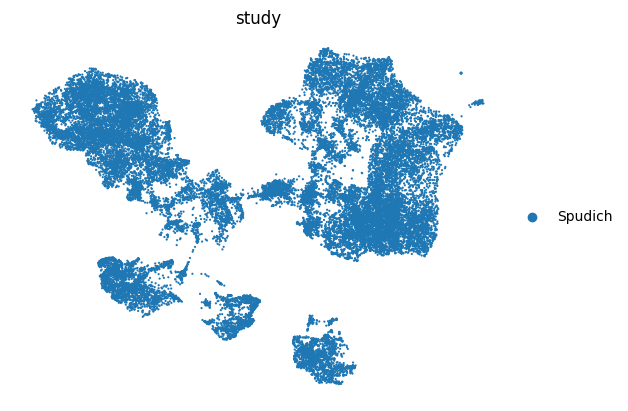

In [5]:
sc.pl.umap(
    inh[np.where((inh.obs.study=='Spudich'))[0]],
    color=["study"],
    frameon=False,
    size=10
)

In [4]:
inh = inh[:,np.where(inh.var.isin(protein_coding_genes))[0]]
inh

View of AnnData object with n_obs × n_vars = 61946 × 17965
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'doublet'
    var: 'gene_ids', 'n_cells'
    uns: 'X_name', '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'subclass_colors', 'subtype_colors', 'umap'
    obsm: 'PCA', 'UMAP', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

In [5]:
sc.pp.filter_genes(inh, min_cells = 10)
inh

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


AnnData object with n_obs × n_vars = 61946 × 17815
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'doublet'
    var: 'gene_ids', 'n_cells'
    uns: 'X_name', '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'subclass_colors', 'subtype_colors', 'umap'
    obsm: 'PCA', 'UMAP', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

In [6]:
inh.var.gene_ids.is_unique

True

# Spudich HIV samples' analysis

In [7]:
# Healthy control samples
controls = list(np.where(
    (inh.obs['sample'].str.contains('HCCCY')) |
    (inh.obs['sample'].str.contains('HCCRS')) |
    (inh.obs['sample'].str.contains('HCTGD')) |
    (inh.obs['sample'].str.contains('HCTKN')) |
    (inh.obs['sample'].str.contains('HCTLI')) |
    (inh.obs['sample'].str.contains('HCTMU')) |
    (inh.obs['sample'].str.contains('HCTMW')) |
    (inh.obs['sample'].str.contains('HCTPK')) |
    (inh.obs['sample'].str.contains('HCTTS')) |
    (inh.obs['sample'].str.contains('HCTXJ')) |
    (inh.obs['sample'].str.contains('HCcPL')) |
    (inh.obs['sample'].str.contains('HCtME')) |
    (inh.obs['sample'].str.contains('HCtNZ'))
)[0])

# HIV samples excluding OUD
hiv = list(np.where(
    (inh.obs['sample'].str.contains('10280')) |
    (inh.obs['sample'].str.contains('10288')) |
    (inh.obs['sample'].str.contains('10304')) |
    (inh.obs['sample'].str.contains('10305')) |
    (inh.obs['sample'].str.contains('1068')) |
    (inh.obs['sample'].str.contains('1129')) |
    (inh.obs['sample'].str.contains('1137')) |
    (inh.obs['sample'].str.contains('6801066772')) |
    (inh.obs['sample'].str.contains('6801187468')) |
    (inh.obs['sample'].str.contains('7100518287')) |
    (inh.obs['sample'].str.contains('7101847783')) |
    (inh.obs['sample'].str.contains('7102096765')) |
    (inh.obs['sample'].str.contains('7200776574')) 
)[0])

# HIV samples with ART
hiv_art = list(np.where(
    (inh.obs['sample'].str.contains('010280')) |
    (inh.obs['sample'].str.contains('010288')) |
    (inh.obs['sample'].str.contains('010304')) |
    (inh.obs['sample'].str.contains('010305')) |
    (inh.obs['sample'].str.contains('1129')) |
    (inh.obs['sample'].str.contains('6801066772')) |
    (inh.obs['sample'].str.contains('6801187468')) |
    (inh.obs['sample'].str.contains('7102096765')) |
    (inh.obs['sample'].str.contains('7201068268'))
)[0])

# HIV samples with no ART
hiv_no_art = list(np.where(
    (inh.obs['sample'].str.contains('1068')) |
    (inh.obs['sample'].str.contains('7100518287')) |
    (inh.obs['sample'].str.contains('7101847783')) |
    (inh.obs['sample'].str.contains('7200776574'))
)[0])

In [8]:
inh[np.where((inh.obs.study=='Spudich'))[0]].obs.subclass.value_counts()

subclass
VIP             9190
PVALB           8168
SST             8057
LAMP5 RELN      2705
PVALB ChC       1706
ADARB2 KCNG1    1586
LAMP5 LHX6      1249
SST HGF           55
SST NPY           22
Name: count, dtype: int64

In [9]:
inh[np.where((inh.obs.study=='Spudich'))[0]].obs.subclass.value_counts()

subclass
VIP             9190
PVALB           8168
SST             8057
LAMP5 RELN      2705
PVALB ChC       1706
ADARB2 KCNG1    1586
LAMP5 LHX6      1249
SST HGF           55
SST NPY           22
Name: count, dtype: int64

LAMP5 LHX6
Num Genes:12486
Num cells:854


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [02:28<00:00,  1.33it/s, v_num=1, train_loss_step=6.09e+3, train_loss_epoch=6.68e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [02:28<00:00,  1.35it/s, v_num=1, train_loss_step=6.09e+3, train_loss_epoch=6.68e+3]


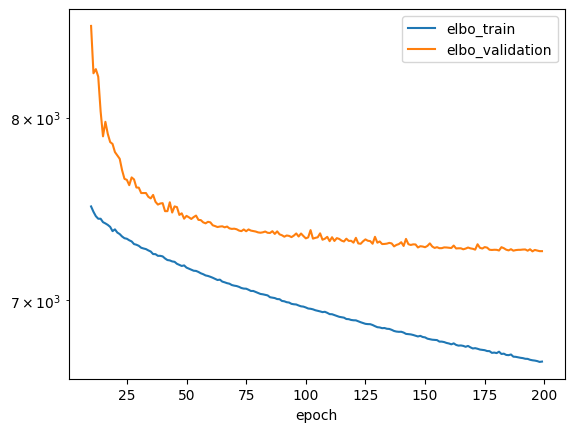

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.55s/it]
LAMP5 RELN
Num Genes:13829
Num cells:1939


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [06:54<00:00,  2.07s/it, v_num=1, train_loss_step=6.67e+3, train_loss_epoch=6.48e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [06:54<00:00,  2.07s/it, v_num=1, train_loss_step=6.67e+3, train_loss_epoch=6.48e+3]


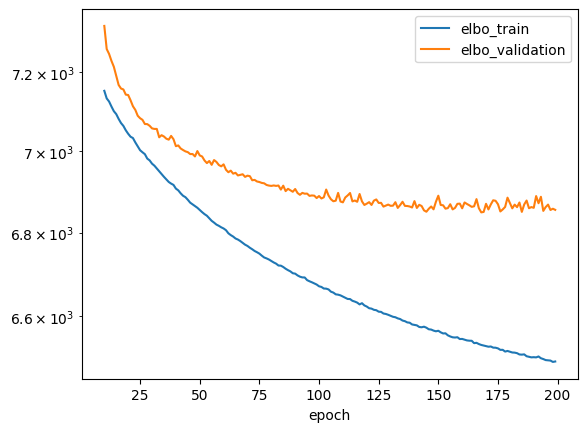

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.02s/it]
PVALB ChC
Num Genes:12608
Num cells:1153


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [03:33<00:00,  1.06s/it, v_num=1, train_loss_step=6.54e+3, train_loss_epoch=6.15e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [03:33<00:00,  1.07s/it, v_num=1, train_loss_step=6.54e+3, train_loss_epoch=6.15e+3]


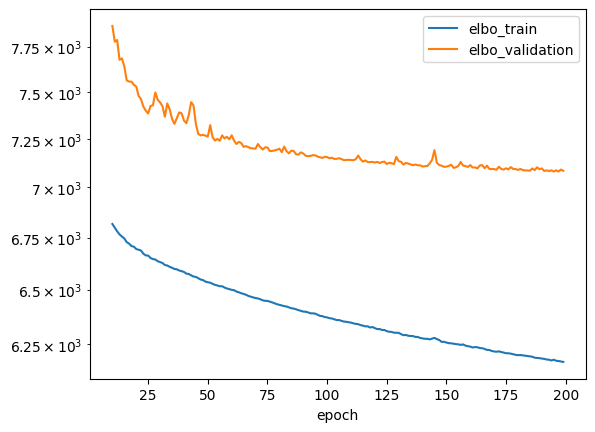

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:35<00:00, 35.74s/it]
PVALB
Num Genes:15352
Num cells:5744


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [48:08<00:00, 14.50s/it, v_num=1, train_loss_step=6.89e+3, train_loss_epoch=6.73e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [48:08<00:00, 14.44s/it, v_num=1, train_loss_step=6.89e+3, train_loss_epoch=6.73e+3]


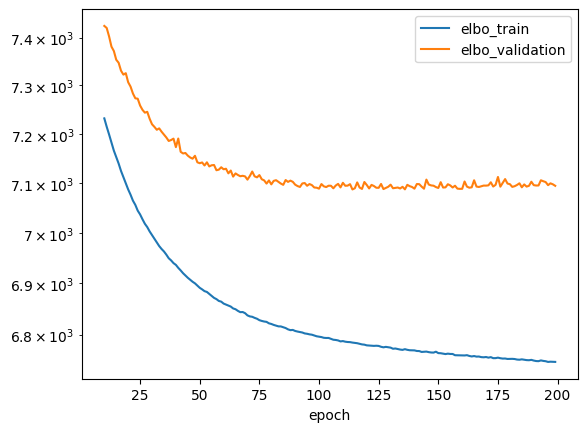

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:57<00:00, 57.95s/it]
SST
Num Genes:15213
Num cells:6275


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [46:30<00:00, 13.96s/it, v_num=1, train_loss_step=5.46e+3, train_loss_epoch=5.63e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [46:30<00:00, 13.95s/it, v_num=1, train_loss_step=5.46e+3, train_loss_epoch=5.63e+3]


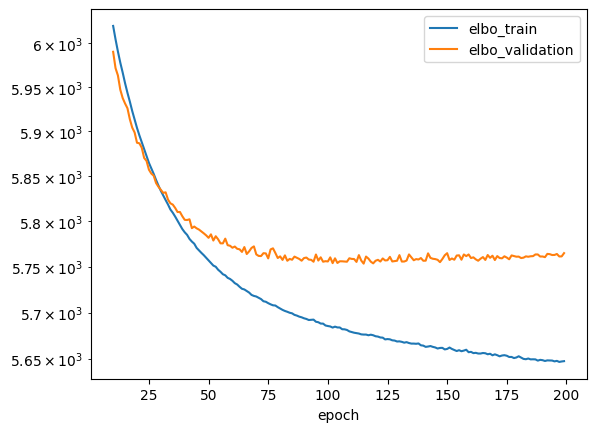

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:57<00:00, 57.72s/it]
ADARB2 KCNG1
Num Genes:12959
Num cells:1201


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [03:30<00:00,  1.04s/it, v_num=1, train_loss_step=5.39e+3, train_loss_epoch=5.62e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 1/200:   0%|                                                                                                                                    | 0/200 [25:21:47<?, ?it/s]


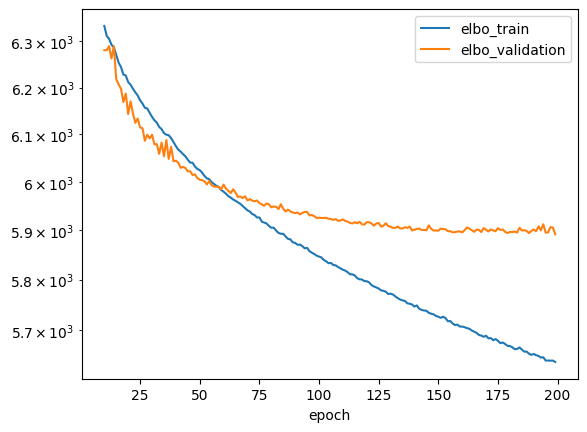

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.43s/it]
SST HGF
Num Genes:5254
Num cells:46


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.34it/s, v_num=1, train_loss_step=6.11e+3, train_loss_epoch=6.11e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.37it/s, v_num=1, train_loss_step=6.11e+3, train_loss_epoch=6.11e+3]


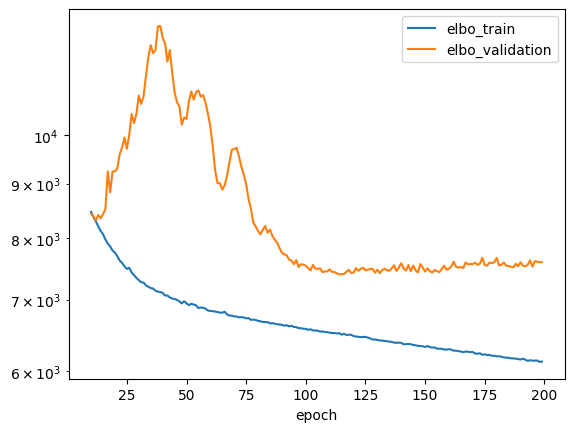

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.06s/it]
SST NPY
Num Genes:2191
Num cells:21


In [13]:
##################################################Parameters:##################################
adata_ref_disease = inh[hiv+controls].copy()
results_dir = '../../results/SCORCH_HIV/diff_exp/inhibitory/hiv_pos_VS_ctrl/'
cond1 = 'hiv'
cond2 = 'ctrl'
adata_ref_disease.obs['condition'] = np.where(((adata_ref_disease.obs['sample'].str.contains('HCCCY')) |
    (adata_ref_disease.obs['sample'].str.contains('HCCRS')) | (adata_ref_disease.obs['sample'].str.contains('HCTGD')) | 
    (adata_ref_disease.obs['sample'].str.contains('HCTKN')) | (adata_ref_disease.obs['sample'].str.contains('HCTLI')) |
    (adata_ref_disease.obs['sample'].str.contains('HCTMU')) | (adata_ref_disease.obs['sample'].str.contains('HCTMW')) |
    (adata_ref_disease.obs['sample'].str.contains('HCTPK')) | (adata_ref_disease.obs['sample'].str.contains('HCTTS')) |
    (adata_ref_disease.obs['sample'].str.contains('HCTXJ')) | (adata_ref_disease.obs['sample'].str.contains('HCcPL')) |
    (adata_ref_disease.obs['sample'].str.contains('HCtME')) | (adata_ref_disease.obs['sample'].str.contains('HCtNZ'))
                                         ),cond2,cond1)
#adata_ref_disease.obs['condition'] = np.where(( (adata_ref_disease.obs['sample'].str.contains('1068')) |
 #                                              (adata_ref_disease.obs['sample'].str.contains('7100518287')) | 
  #                                             (adata_ref_disease.obs['sample'].str.contains('7101847783')) |
   #                                            (adata_ref_disease.obs['sample'].str.contains('7200776574'))
    #),'hiv_no_art','hiv_art')
###############################################################################################
#sc.pp.filter_genes(adata_ref_disease, min_cells = 10)
#sc.pp.highly_variable_genes(
 #       adata_ref_disease,
  #      n_top_genes=10000,
   #     subset=True,
    #    flavor="seurat_v3"
     #   )
scvi.model.SCVI.setup_anndata(adata_ref_disease, #layer="UMIs",
                              categorical_covariate_keys=['sample']
                              #continuous_covariate_keys=["Age at Death"]
                             )
model = scvi.model.SCVI(
    adata_ref_disease, gene_likelihood="nb"
    )  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
model.train(
    check_val_every_n_epoch=1,
    max_epochs=300,
    early_stopping=True,
    early_stopping_patience=20,
    early_stopping_monitor="elbo_validation",
    )
train_test_results = model.history["elbo_train"]
train_test_results["elbo_validation"] = model.history["elbo_validation"]
train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
plt.show()

de_change = model.differential_expression(idx1=adata_ref_disease.obs['condition']==cond1,
                                          idx2=adata_ref_disease.obs['condition']==cond2, weights='uniform')

#de = de_change.loc[de_change['is_de_fdr_0.05']==True,:]
de_change["log10_pscore"] = (-1)*np.log10(de_change["proba_not_de"])
de_change.to_csv(results_dir+'allcells_protein_coding.tsv',sep='\t')
#de_change.to_csv(results_dir+'_allcells.tsv',sep='\t')

for cell_type in pd.unique(adata_ref_disease.obs.subclass):
    #if cell_type=='VIP': continue
    print(cell_type)
    cells = list(np.where(adata_ref_disease.obs.subclass==cell_type)[0])
    adata_cell = adata_ref_disease[cells].copy()
    sc.pp.filter_genes(adata_cell, min_cells = 10)
    #sc.pp.highly_variable_genes(
     #   adata_cell,
      #  n_top_genes=5000,
       # subset=True,
        #flavor="seurat_v3"
        #)
    print("Num Genes:"+str(len(adata_cell.var)))
    print('Num cells:'+str(len(adata_cell.obs)))
    ####################################Skip the cell type with fewer than 10 cells in each condition#######################
    if (len(np.where(adata_cell.obs['condition']==cond1)[0])<10) or (len(np.where(adata_cell.obs['condition']==cond2)[0])<10):
        continue
    #########################################################################################################################
    scvi.model.SCVI.setup_anndata(adata_cell, #layer="UMIs",
                                  categorical_covariate_keys=['sample']
                                  #continuous_covariate_keys=["Age at Death"]
                                 )
    model = scvi.model.SCVI(
        adata_cell, gene_likelihood="nb")  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
    model.train(
        check_val_every_n_epoch=1,
        max_epochs=200,
        early_stopping=True,
        early_stopping_patience=100,
        early_stopping_monitor="elbo_validation",
        batch_size=103,
        plan_kwargs={"lr": 0.001}
        )
    train_test_results = model.history["elbo_train"]
    train_test_results["elbo_validation"] = model.history["elbo_validation"]
    train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
    plt.show()
    de_change = model.differential_expression(idx1=adata_cell.obs['condition']==cond1,
                                       idx2=adata_cell.obs['condition']==cond2, weights="uniform")
    
    #de_change = de_change.loc[de['is_de_fdr_0.05']==True,:]
    de_change.loc[:,"log10_pscore"] = (-1)*np.log10(de_change["proba_not_de"])
    cell_type = cell_type.replace('/','')
    cell_type = cell_type.replace(" ","")
    de_change.to_csv(results_dir+cell_type+'_protein_coding.tsv',sep='\t')

## GSEA

In [14]:
gene_sets_to_test = ['GO_Biological_Process_2023','GO_Cellular_Component_2023','GO_Molecular_Function_2023',
                    'WikiPathway_2023_Human',
                    'MSigDB_Hallmark_2020',
                    'KEGG_2021_Human']

In [18]:
file_path_diff_exp = '../../results/SCORCH_HIV/diff_exp/inhibitory/hiv_pos_VS_ctrl/'
file_path_gmt = '../../gene_sets/'
gsea_on = 'all_de_genes/'#'all_de_genes' or 'positive_regulated' or 'negative_regulated'
results_dir = '../../results/SCORCH_HIV/gsea/inhibitory/'+gsea_on+'hiv_pos_VS_ctrl/'#Make sure correct DEG data frame is read as 'input_gsea'

for file in os.listdir(file_path_diff_exp):
    if 'tsv' in file:
        diff_exp = pd.read_csv(file_path_diff_exp+file, sep='\t',index_col=0)
        diff_exp.loc[:,'sign_lfc']=np.where(diff_exp['lfc_median']<0,-1,1)
        file = file.replace(" ","")
        cell_type = "".join(i for i in file.split('_')[0]).replace('.tsv',"")
        print(cell_type)
        
        ######################## For all DEGs or separate +ve and -ve regulated genes############################
        col = np.where(diff_exp.columns=='log10_pscore')[0]
        diff_exp.loc[:,'metric_gsea'] = diff_exp['log10_pscore']*diff_exp['sign_lfc']
        input_gsea = pd.DataFrame(columns=['metric_gsea'])
        
        if gsea_on=='all_de_genes/':
            input_gsea = diff_exp.loc[:,'metric_gsea']
        #Positive DEGs:
        elif gsea_on=='upreg_genes/':
            input_gsea = diff_exp.iloc[list(np.where(diff_exp['lfc_median']>0)[0]),'metric_gsea']        
        #Negative DEGs
        elif gsea_on=='downreg_genes/':
            input_gsea = diff_exp.iloc[np.where(diff_exp.lfc_median<0)[0],'metric_gsea']

        input_gsea = input_gsea.sort_values(ascending=False)
        gsea_all_paths = pd.DataFrame()
        
        ## Exception handling for when the gmt gene set is irrelevant for the differentially expressed genes
        try:
            gsea_result = gseapy.prerank(rnk=input_gsea, gene_sets=gene_sets_to_test, organism='human')
        except LookupError:
            continue
        #filtered_sets = gsea_result.res2d.iloc[
                                            #np.where((gsea_result.res2d['NOM p-val']<=0.05)&
                                                    #(gsea_result.res2d['FDR q-val']<=0.25))[0]
                                            #,:]
        filtered_sets = gsea_result.res2d
        if len(filtered_sets)>0:
            gsea_all_paths = pd.concat([gsea_all_paths,filtered_sets]).reset_index(drop=True)
            gsea_all_paths=gsea_all_paths.drop_duplicates()
            gsea_all_paths.to_csv(results_dir+cell_type+'.tsv', sep='\t',index=False)

2024-06-07 20:01:53,720 [WARNING] Duplicated values found in preranked stats: 76.42% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


LAMP5RELN


2024-06-07 20:11:52,185 [WARNING] Duplicated values found in preranked stats: 75.62% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


VIP


2024-06-07 20:23:57,768 [WARNING] Duplicated values found in preranked stats: 73.64% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


PVALBChC


2024-06-07 20:32:33,139 [WARNING] Duplicated values found in preranked stats: 76.21% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


allcells


2024-06-07 20:47:37,588 [WARNING] Duplicated values found in preranked stats: 75.57% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


SST


2024-06-07 20:59:27,368 [WARNING] Duplicated values found in preranked stats: 75.61% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


LAMP5LHX6


2024-06-07 21:07:49,399 [WARNING] Duplicated values found in preranked stats: 71.56% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


SSTHGF
Epoch 1/200:   0%|                                                                                                                                    | 0/200 [21:41:56<?, ?it/s]


2024-06-07 21:10:02,581 [WARNING] Duplicated values found in preranked stats: 73.38% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


PVALB


2024-06-07 21:21:57,007 [WARNING] Duplicated values found in preranked stats: 78.28% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


ADARB2KCNG1


In [1]:
def get_all_DEG(file_path_diff_exp):
    all_DEG = pd.DataFrame()
    for file in os.listdir(file_path_diff_exp):
        if 'tsv' in file and 'lfc' not in file and 'allcells' not in file:
            diff_exp = pd.read_csv(file_path_diff_exp+file, sep='\t',index_col=0)
            file = file.replace(" ","")
            cell_type = "".join(i for i in file.split('_')[0]).replace('.tsv',"")
            diff_exp.loc[:,'cell_type'] = cell_type
            diff_exp = diff_exp.reset_index().rename(columns={"index":'gene'})
        
            ######For numerical stability: replace infinite values with twice of maximum
            max_twice = diff_exp.loc[diff_exp['log10_pscore'] != np.inf, 'log10_pscore'].max()*2
            diff_exp['log10_pscore'].replace(np.inf,max_twice,inplace=True)
                
            #volcano(diff_exp,cell_type, file_path_diff_exp)
            all_DEG = pd.concat([all_DEG,diff_exp]) #Read in and saved in a previous run is used further in the volcano plot function
    all_DEG = all_DEG.reset_index(drop=True)
    return all_DEG

In [4]:
def get_selection_metric(df):
    selection_metric = df['bayes_factor'] * abs(df['lfc_median'])
    df.loc[:,'selection_metric'] = selection_metric
    return df

In [5]:
def consensus_degs(all_deg_frame,direction):
    consensus_genes=[]
    for gene in pd.unique(all_deg_frame.loc[np.where(all_deg_frame['is_de_fdr_0.05']==True)[0],'gene_ids']):
        if gene not in consensus_genes:
            if direction=='up':
                temp = all_deg_frame.iloc[np.where((all_deg_frame.gene_ids==gene)&(all_deg_frame['is_de_fdr_0.05']==True)
                                                   &(all_deg_frame['lfc_median']>0)
                )[0],:]
            elif direction=='down':
                temp = all_deg_frame.iloc[np.where((all_deg_frame.gene_ids==gene)&(all_deg_frame['is_de_fdr_0.05']==True)
                                                   &(all_deg_frame['lfc_median']<0)
                )[0],:]
            if len(temp) >= 2:
                consensus_genes.append(gene)
    return consensus_genes

In [6]:
all_deg_inh = get_all_DEG('../../results/SCORCH_HIV/diff_exp/inhibitory/hiv_pos_VS_ctrl/')
all_deg_inh = get_selection_metric(all_deg_inh)

In [7]:
all_deg_inh

,gene_ids,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,log10_pscore,cell_type,selection_metric
0,CRH,0.9776,0.0224,3.776039,2.642893e-05,3.354727e-04,0.0,0.25,-4.618707,-4.477237,...,0.094737,1.883523,0.064777,0.602273,0.136061,2.697224,True,1.649752,LAMP5RELN,16.906222
1,TM9SF1,0.9768,0.0232,3.740129,2.902784e-07,3.265145e-06,0.0,0.25,-3.982394,-4.048529,...,0.001619,0.022727,0.001619,0.022727,0.003009,0.027550,True,1.634512,LAMP5RELN,15.142021
2,FKBP2,0.9754,0.0246,3.680101,1.756430e-07,1.989430e-06,0.0,0.25,-4.293537,-4.401070,...,0.002429,0.014205,0.002429,0.014205,0.003761,0.017000,True,1.609065,LAMP5RELN,16.196380
3,TG,0.9754,0.0246,3.680101,2.597809e-06,2.823000e-07,0.0,0.25,4.166291,4.392832,...,0.012955,0.002841,0.012146,0.001420,0.038761,0.002519,True,1.609065,LAMP5RELN,16.166065
4,EMC6,0.9742,0.0258,3.631242,2.170689e-06,1.483177e-05,0.0,0.25,-4.115315,-4.037933,...,0.008097,0.085227,0.008097,0.076705,0.011680,0.120828,True,1.588380,LAMP5RELN,14.662712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103097,FAF1,0.5154,0.4846,0.061619,4.559142e-04,4.503356e-04,0.0,0.25,0.017260,0.007948,...,1.679128,2.574240,0.700935,0.815742,4.622350,4.124685,False,0.314617,ADARB2KCNG1,0.000490
103098,SBF2,0.5138,0.4862,0.055214,5.045777e-04,5.171333e-04,0.0,0.25,-0.030692,-0.019215,...,1.861371,3.173524,0.710280,0.817531,4.925687,4.897283,False,0.313185,ADARB2KCNG1,0.001061
103099,UNC79,0.5080,0.4920,0.032003,5.302689e-04,5.907481e-04,0.0,0.25,-0.156704,-0.158653,...,1.909657,3.919499,0.727414,0.872987,5.232241,6.249791,False,0.308035,ADARB2KCNG1,0.005077
103100,JMJD1C,0.4790,0.5210,-0.084049,8.826677e-04,8.538159e-04,0.0,0.25,0.048198,0.041834,...,3.137072,5.688730,0.866044,0.937388,8.685658,9.042125,False,0.283162,ADARB2KCNG1,-0.003516


In [8]:
consensus_genes_up=consensus_degs(all_deg_inh,'up')
len(consensus_genes_up)

166

In [9]:
consensus_genes_down=consensus_degs(all_deg_inh,'down')
len(consensus_genes_down)

639

In [11]:
str(set(consensus_genes_up).intersection(consensus_genes_down))

"{'TMEM98', 'FBN2', 'LRP4', 'SYK', 'SHROOM4', 'EYA4', 'FGD3', 'DOCK5', 'IFI44', 'TGFBR2', 'SLC17A8', 'KLHL14', 'THSD7B', 'TMEM200A', 'TRPC6', 'FLI1'}"

In [17]:
all_deg_inh.loc[np.where(
    #(all_deg_inh.gene_ids.isin(consensus_genes_down))&
    (all_deg_inh['is_de_fdr_0.05']==True)&(all_deg_inh.gene_ids.str.contains('FGD3'))
)[0],:]

,gene_ids,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,log10_pscore,cell_type,selection_metric
700,FGD3,0.9432,0.0568,2.809742,1.824940e-06,1.122092e-06,0.0,0.25,1.399206,1.457822,...,0.008907,0.009943,0.008907,0.008523,0.022543,0.011575,True,1.245652,LAMP5RELN,4.096103
14293,FGD3,0.9450,0.0550,2.843852,7.887021e-07,8.504408e-07,0.0,0.25,-1.022117,-1.000328,...,0.006460,0.005652,0.005384,0.004845,0.008767,0.005749,True,1.259637,VIP,2.844785
42442,FGD3,0.9444,0.0556,2.832366,1.235632e-05,1.654554e-05,0.0,0.25,-0.213339,-0.223907,...,0.035005,0.093037,0.032118,0.077911,0.109056,0.175611,True,1.254925,SST,0.634185
90511,FGD3,0.9486,0.0514,2.915349,5.603943e-06,3.307889e-06,0.0,0.25,1.411194,1.417937,...,0.023364,0.007156,0.021807,0.007156,0.077986,0.019369,True,1.289037,ADARB2KCNG1,4.133782


In [21]:
str(consensus_genes_down)

"['CRH', 'FKBP2', 'EMC6', 'POMC', 'SST', 'LKAAEAR1', 'ADAM28', 'RBP4', 'MAP7D3', 'CLCA4', 'RAMP2', 'GMPPB', 'FAM174C', 'FLI1', 'PSENEN', 'BLOC1S1', 'MFSD3', 'TGFBR3L', 'APRT', 'NRN1', 'MTX1', 'NUDT14', 'COX6A1', 'PET117', 'ZFP36', 'TRPT1', 'ETFB', 'CORT', 'H2BC4', 'VKORC1', 'IKZF1', 'LENG1', 'KRT17', 'JTB', 'NDUFB11', 'NUDT1', 'SHISA4', 'CCN3', 'TNNI3', 'ANTKMT', 'CHRNB1', 'SSR4', 'NR2C2AP', 'SCO2', 'TAC1', 'DNPH1', 'POP7', 'BORCS6', 'MRPL54', 'NDUFB8', 'VIPR2', 'PRAF2', 'LAGE3', 'ITGA2', 'DOCK5', 'VGF', 'TMEM208', 'DCAF12L2', 'LY86', 'CRABP1', 'COX14', 'TUSC1', 'MEA1', 'SPDYE2', 'NDUFA13', 'NEDD8', 'LIX1', 'EEF1E1', 'FBN2', 'AVPR1A', 'NKX6-2', 'MS4A13', 'PAQR4', 'RELN', 'SPEF1', 'GJB1', 'NME1', 'CMTM5', 'FJX1', 'KLHL14', 'CD86', 'TIMM17B', 'SYK', 'LGALS1', 'NT5C', 'MED11', 'STAC', 'TIMM13', 'OLIG2', 'SYT9', 'CCDC85B', 'RPS27A', 'HSPB2', 'CD53', 'DCTN3', 'CPB2', 'BVES', 'INAFM1', 'PHGDH', 'TOMM22', 'ATP5MF', 'LIN7B', 'VRK2', 'CDK5', 'DUSP23', 'NR4A2', 'SELENOW', 'PGAM2', 'FA2H', 'CALCR

In [27]:
str(set(consensus_genes_down).intersection({'OR2H2', 'TRAF3IP3', 'TMEM31', 'TMEFF1', 'VAV3', 'MESP2', 'THSD7B', 'VCAN', 'PENK', 'LY6D', 'PSMB10', 
                                'FLG', 'KLRB1', 'VGF', 'PRSS16', 'SALL3', 'RAMP2', 'GNAT2', 'ALPL', 'ENSG00000266997', 'CHRM2', 'HPR', 
                                'EMC6', 'ADGRG6', 'GPR18', 'GPR171', 'G0S2', 'CRH', 'CCK', 'SLC10A1', 'TNC', 'HBA1', 'DCC', 'PRDM7', 'HBQ1',
                                'APBB1IP', 'RGL4', 'IFI44L', 'SLITRK6', 'ADAMTS9', 'NR2C2AP', 'PAMR1', 'SLC38A5', 'FAM89A', 'CX3CR1', 
                                'PSENEN', 'COL4A5', 'RRAS', 'ITGAX', 'NPY', 'SPSB4', 'PERM1', 'SST', 'CLDN20', 'ADM5', 'CBLN4', 'MFGE8', 
                                'NXPH1', 'SDF2L1', 'GRIK1', 'FRMD4B', 'TUSC1', 'GARIN6', 'IKZF1', 'CDH19', 'ZDHHC12', 'ALKAL2', 'CRABP1',
                                'SLC30A3', 'TMSB4Y', 'ST8SIA2', 'CALB1', 'NPM3', 'EGFR', 'CHD7', 'EMX2', 'SLC25A48', 'FA2H', 'PI16', 'VEGFC',
                                'TMEM235', 'HES4', 'CLXN', 'SPRY4', 'ABCC12', 'ADRA1D', 'ETV1', 'UST', 'KRT5', 'SLN', 'HHATL', 'HCRTR1',
                                'KIF2B', 'NREP', 'COX8A', 'TSTD1', 'CMTM5', 'MGP', 'TTC9B', 'BLOC1S1', 'RGS1', 'MICOS13', 'TRIM77', 'TMEM141',
                                'LORICRIN', 'GNG3', 'GASK1B', 'SPDYE2', 'RPP25L', 'KRT17', 'CCDC166', 'MRPL54', 'CFHR4', 'PTGER4', 'HDC', 'PTRHD1',
                                'CDK1', 'NEDD8', 'CHST3', 'DUSP6', 'CORT', 'UBL5', 'ASPA', 'COL11A1', 'MT-ATP6', 'RNASE1', 'FAM181A',
                                'RPS27A', 'NUDT1', 'CYSRT1', 'BEND4', 'PSMB6', 'AGBL1', 'ANAPC15', 'PRDX5', 'ADARB2', 'VRK2', 'DACH1', 
                                'SPHKAP', 'MRPL36', 'PVALB', 'WNT9A', 'OLIG1', 'NPAS4', 'ANKRD55', 'VIPR2', 'MYB', 'NEUROD6', 'NCBP2AS2',
                                'TXNDC17', 'PPP1R14A', 'FGF16', 'PCDH11Y', 'FAU', 'MUC15', 'GRIN3A', 'POLR2L', 'NUDT14', 'PRR29', 'ST18',
                                'PHPT1', 'BBLN', 'LGALS1', 'SLCO1B1', 'MKRN3', 'SMIM32', 'SHC4', 'NR4A3', 'POU6F2', 'AVP', 'SMOC2', 'FOLH1',
                                'IRF8', 'TRIB1', 'PRSS12', 'FAM240C', 'KIAA1755', 'PDXP', 'POMC', 'HAS2', 'CEACAM21', 'FLI1', 'GARIN5A',
                                'TAL1', 'RXRG', 'DOCK8', 'SLC22A3', 'ENSG00000283886', 'ZNF728', 'MNDA', 'ZIC1', 'NTNG1', 'MET', 'PPP3R2', 
                                'GIMAP8', 'NDUFB11', 'TAC1', 'PRIMA1', 'SCO2', 'TGFBR3L', 'CD86', 'SHROOM4', 'NDST4', 'RPRM', 'KCNH8', 
                                'ATP5MF', 'PIK3R5', 'NOTCH1', 'HEY2', 'CCL4', 'UFSP1', 'UCP1', 'ABCA8', 'GALR1', 'GPX4', 'SSR4', 'NPBWR2', 
                                'OPALIN', 'TMEM208', 'PROC', 'ARL4D', 'ANKRD34B', 'SLC5A8', 'TMEM200A', 'GIMAP4', 'CPB1', 'RPEL1', 
                                'RARRES2', 'GSG1', 'H2AC15', 'PET117', 'PDGFRA', 'CHAC1', 'DUSP10', 'BCHE', 'P2RY13', 'FAM174C', 'EGR2', 
                                'ASCL1', 'TRPT1', 'ENSG00000285269', 'DNPH1', 'ANKRD53', 'BLNK', 'SLC2A2', 'DOCK10', 'CTXN1', 'GAD2', 'NPB', 
                                'COX14', 'H2AC8', 'FBXL7', 'CBX2', 'ZFHX4', 'RTP1', 'SELENOM', 'PRELID1', 'TMCC3', 'PCP4', 'ZNF536', 'ARHGAP31',
                                'TMEM273', 'MIF', 'ATP5MC1', 'FGFR2', 'VIP', 'STING1', 'CDKN2A', 'PCDH18', 'ATP11C', 'TMEM52B', 'SLCO1A2', 'GAD1',
                                'BICDL2', 'OLIG2', 'NKD1', 'RELN', 'LAGE3', 'ITPKB', 'COX7A1', 'ARX', 'UGT8', 'SYT6', 'TLL1', 'ARSJ', 'IGFBP6', 
                                'PLCXD3', 'ART4', 'CYP2J2', 'CLDN1', 'HSD17B8', 'ATP10B', 'ARF5', 'CERCAM', 'LPAR1', 'THSD7A', 'ITGA2', 'COX6A1', 
                                'HSPB3', 'GNAT3', 'SH3TC2', 'MRPL12', 'HTR2C', 'COBLL1', 'DCTPP1', 'HBA2', 'DCLRE1B', 'HPSE2', 'RFTN2', 'PTPRC',
                                'PTPRZ1', 'RTBDN', 'CPED1', 'EVI2B', 'DOCK5', 'MOG', 'ENPP2', 'ATP5F1D', 'DUSP2', 'FYB1', 'COL9A2', 'EBF1', 
                                'EEF1E1', 'CUX2', 'ISLR', 'TLR10', 'ELOB', 'DOCK1', 'TMSB10', 'PREX2', 'TMEM63A', 'SALL1', 'BCAS1', 'DDX53', 
                                'RPS19BP1', 'LYPD6B', 'PPM1J', 'KLK6', 'NFKBIE', 'PARD3B', 'ALYREF', 'PALMD', 'PON2', 'MRPL40', 'PLPP2', 'PLLP',
                                'ZNF593', 'PTPMT1', 'POLR2I', 'SLC24A5', 'PFN1', 'NDUFAF3', 'STPG4', 'SHISAL1', 'CA2', 'ZCCHC24', 'SLC22A10', 
                                'PLEKHG3', 'DAAM2', 'EGR4', 'PIEZO2', 'DLL3', 'INSYN2B', 'PCED1B', 'CDK18', 'CLCA4', 'OR8D1', 'IL1RAPL2', 'ROMO1',
                                'KNCN', 'LPAR3', 'BEX5', 'DNLZ', 'ERAS', 'KCNE3', 'RERGL', 'KCNK2'}))

"{'TMEM208', 'UGT8', 'HES4', 'KCNH8', 'VIP', 'ZCCHC24', 'SH3TC2', 'NR2C2AP', 'SELENOM', 'RPS19BP1', 'NUDT1', 'PLCXD3', 'APBB1IP', 'COX14', 'TAL1', 'TMEFF1', 'DUSP6', 'ABCA8', 'HTR2C', 'KRT17', 'MRPL54', 'POLR2I', 'ATP5F1D', 'GPX4', 'ATP5MC1', 'ENSG00000285269', 'GIMAP8', 'HHATL', 'ZNF593', 'ATP5MF', 'TNC', 'PI16', 'NUDT14', 'CLCA4', 'MOG', 'DNPH1', 'RPP25L', 'FGFR2', 'HCRTR1', 'THSD7B', 'PENK', 'POMC', 'DCTPP1', 'COL4A5', 'ROMO1', 'OLIG1', 'SDF2L1', 'BBLN', 'EMC6', 'CALB1', 'KIAA1755', 'PSMB6', 'IGFBP6', 'POLR2L', 'TSTD1', 'IKZF1', 'VGF', 'SHROOM4', 'DOCK5', 'CRH', 'DAAM2', 'KLRB1', 'FLI1', 'GNG3', 'TGFBR3L', 'ITGAX', 'ST18', 'TTC9B', 'CX3CR1', 'NDUFAF3', 'PIEZO2', 'NOTCH1', 'NCBP2AS2', 'PRELID1', 'GARIN5A', 'RXRG', 'ZNF728', 'CD86', 'IRF8', 'VIPR2', 'TRPT1', 'KLK6', 'HBQ1', 'VEGFC', 'NEDD8', 'SST', 'SPDYE2', 'TMEM273', 'NFKBIE', 'TAC1', 'NPAS4', 'TMEM141', 'PCED1B', 'ARL4D', 'CBLN4', 'ARSJ', 'PSENEN', 'PRDX5', 'EEF1E1', 'BCHE', 'MRPL40', 'MICOS13', 'PTPRC', 'FAM174C', 'ALYREF', 'PET11

In [28]:
all_deg_inh.loc[np.where(
    #(all_deg_inh.gene_ids.isin(consensus_genes_down))&
    (all_deg_inh['is_de_fdr_0.05']==True)&(all_deg_inh.gene_ids.isin(['CCK','NPY','PENK','VGF']))
)[0],:]

,gene_ids,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,log10_pscore,cell_type,selection_metric
89,VGF,0.9582,0.0418,3.132160,2.073918e-06,0.000011,0.0,0.25,-2.651365,-2.520071,...,0.009717,0.061080,0.009717,0.041193,0.018104,0.077091,True,1.378824,LAMP5RELN,7.893265
185,NPY,0.9538,0.0462,3.027474,1.119857e-06,0.000009,0.0,0.25,-2.519211,-2.548597,...,0.003239,0.083807,0.003239,0.022727,0.007225,0.125937,True,1.335358,LAMP5RELN,7.715812
402,CCK,0.9482,0.0518,2.907175,1.397337e-04,0.000573,0.0,0.25,-2.355369,-2.385127,...,0.609717,3.599432,0.312551,0.812500,1.077110,5.193334,True,1.285670,LAMP5RELN,6.933981
13862,VGF,0.9628,0.0372,3.253537,1.684430e-05,0.000082,0.0,0.25,-2.835053,-2.896429,...,0.072140,0.441260,0.055989,0.299556,0.138074,0.784597,True,1.429457,VIP,9.423640
14047,NPY,0.9514,0.0486,2.974311,6.109949e-07,0.000003,0.0,0.25,-2.091370,-2.140392,...,0.001346,0.013323,0.001346,0.010900,0.004521,0.026429,True,1.313364,VIP,6.366192
14087,PENK,0.9500,0.0500,2.944439,4.194702e-06,0.000013,0.0,0.25,-2.058587,-2.036217,...,0.024495,0.123537,0.007268,0.014534,0.030177,0.127989,True,1.301030,VIP,5.995515
14114,CCK,0.9490,0.0510,2.923583,1.609161e-04,0.000753,0.0,0.25,-2.225008,-2.319203,...,0.631225,4.207509,0.272140,0.630602,1.432466,7.086704,True,1.292430,VIP,6.780384
29230,VGF,0.9768,0.0232,3.740129,8.512481e-06,0.000073,0.0,0.25,-3.738717,-3.686617,...,0.029412,0.484288,0.027778,0.329020,0.043804,0.782175,True,1.634512,PVALBChC,13.788425
29534,CCK,0.9432,0.0568,2.809742,2.299370e-05,0.000092,0.0,0.25,-2.238274,-2.216277,...,0.088235,0.571165,0.080065,0.375231,0.210668,0.958377,True,1.245652,PVALBChC,6.227167
41956,PENK,0.9570,0.0430,3.102603,1.323285e-05,0.000032,0.0,0.25,-0.919716,-0.906342,...,0.036449,0.143550,0.031757,0.083619,0.133130,0.242719,True,1.366532,SST,2.812018


## Create pseudobulks

In [10]:
pseudobulk_adata = dc.get_pseudobulk(
    inh[controls+hiv],
    sample_col='sample',
    groups_col='subclass',
    #layer='UMIs',
    mode='sum',
    min_cells=0,
    min_counts=0
)
pseudobulk_adata

AnnData object with n_obs × n_vars = 200 × 17802
    obs: 'orig.ident', 'sample', 'study', 'subclass', 'class', '_scvi_batch', '_scvi_labels', 'doublet', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids', 'n_cells'
    layers: 'psbulk_props'

In [11]:
pseudobulk_adata.obs

,orig.ident,sample,study,subclass,class,_scvi_batch,_scvi_labels,doublet,psbulk_n_cells,psbulk_counts
10280_HIV_PFC_ADARB2 KCNG1,SeuratProject,10280_HIV_PFC,Spudich,ADARB2 KCNG1,InN,0,0,singlet,112.0,455422.0
10288_HIV_PFC_ADARB2 KCNG1,SeuratProject,10288_HIV_PFC,Spudich,ADARB2 KCNG1,InN,0,0,singlet,23.0,64168.0
10304_HIV_PFC_ADARB2 KCNG1,SeuratProject,10304_HIV_PFC,Spudich,ADARB2 KCNG1,InN,0,0,singlet,165.0,581568.0
10305_HIV_PFC_ADARB2 KCNG1,SeuratProject,10305_HIV_PFC,Spudich,ADARB2 KCNG1,InN,0,0,singlet,42.0,141777.0
1068_HIV_PFC_ADARB2 KCNG1,SeuratProject,1068_HIV_PFC,Spudich,ADARB2 KCNG1,InN,0,0,singlet,79.0,359783.0
...,...,...,...,...,...,...,...,...,...,...
HCTTS_CTR_PFC_MAH_VIP,SeuratProject,HCTTS_CTR_PFC_MAH,Spudich,VIP,InN,0,0,singlet,137.0,1104631.0
HCTXJ_CTR_PFC_VIP,SeuratProject,HCTXJ_CTR_PFC,Spudich,VIP,InN,0,0,singlet,428.0,1904737.0
HCcPL_CTR_PFC_MAH_VIP,SeuratProject,HCcPL_CTR_PFC_MAH,Spudich,VIP,InN,0,0,singlet,95.0,600769.0
HCtME_CTR_PFC_MAH_VIP,SeuratProject,HCtME_CTR_PFC_MAH,Spudich,VIP,InN,0,0,singlet,197.0,1654737.0


In [12]:
pbulk_controls = list(np.where(
(pseudobulk_adata.obs['sample'].str.contains('CTR'))
)[0])


################ HIV samples ####################
pbulk_hiv = list(np.where(
(pseudobulk_adata.obs['sample'].str.contains('HIV'))
)[0])

In [16]:
pd.DataFrame(data=pseudobulk_adata.X[pbulk_controls],
             columns=pseudobulk_adata.var.iloc[:,0],
             index=pseudobulk_adata.obs.index[pbulk_controls]).T.to_csv('../../HIV_data/single_cell_scorch/inh_v2_pbulk_controls.tsv',sep='\t')

pd.DataFrame(data=pseudobulk_adata.X[pbulk_hiv],
             columns=pseudobulk_adata.var.iloc[:,0],
             index=pseudobulk_adata.obs.index[pbulk_hiv]).T.to_csv('../../HIV_data/single_cell_scorch/inh_v2_pbulk_hiv.tsv',sep='\t')


## Kellis OUD samples

In [7]:
# Healthy control samples from Kellis study
controls_oud = list(np.where(
    (inh.obs['sample'].str.contains('HCtDL')) |
    (inh.obs['sample'].str.contains('HCtIU')) |
    (inh.obs['sample'].str.contains('HCtPA')) |
    (inh.obs['sample'].str.contains('HCtRP')) |
    (inh.obs['sample'].str.contains('HCtQQ')) |
    (inh.obs['sample'].str.contains('HCtVE')) |
    (inh.obs['sample'].str.contains('HCtVF')) |
    (inh.obs['sample'].str.contains('HCtWL')) |
    (inh.obs['sample'].str.contains('HCtDI'))
)[0])

# OUD samples
oud = list(np.where(
    (inh.obs['sample'].str.contains('HCcLS')) |
    (inh.obs['sample'].str.contains('HCcPN')) |
    (inh.obs['sample'].str.contains('HCcOV')) |
    (inh.obs['sample'].str.contains('HCcHO')) |
    (inh.obs['sample'].str.contains('HCcOE')) |
    (inh.obs['sample'].str.contains('HCcFW')) |
    (inh.obs['sample'].str.contains('NIH1308')) |
    (inh.obs['sample'].str.contains('HCCWQ')) |
    (inh.obs['sample'].str.contains('HccUD')) |
    (inh.obs['sample'].str.contains('HCcWK'))
)[0])

In [8]:
pseudobulk_adata_oud = dc.get_pseudobulk(
    inh[oud+controls_oud],
    sample_col='sample',
    groups_col='subclass',
    #layer='UMIs',
    mode='sum',
    min_cells=0,
    min_counts=0
)
pseudobulk_adata_oud

AnnData object with n_obs × n_vars = 128 × 17486
    obs: 'orig.ident', 'sample', 'study', 'subclass', 'class', '_scvi_batch', '_scvi_labels', 'doublet', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids', 'n_cells'
    layers: 'psbulk_props'

In [9]:
pseudobulk_adata_oud.obs

,orig.ident,sample,study,subclass,class,_scvi_batch,_scvi_labels,doublet,psbulk_n_cells,psbulk_counts
HCCWQ_09_BA9-FC_ADARB2 KCNG1,SeuratProject,HCCWQ_09_BA9-FC,Kellis,ADARB2 KCNG1,InN,0,0,singlet,13.0,99003.0
HCcFW_07_BA9-FC_ADARB2 KCNG1,SeuratProject,HCcFW_07_BA9-FC,Kellis,ADARB2 KCNG1,InN,0,0,singlet,14.0,100269.0
HCcHO_05_BA9-FC_ADARB2 KCNG1,SeuratProject,HCcHO_05_BA9-FC,Kellis,ADARB2 KCNG1,InN,0,0,singlet,3.0,19174.0
HCcLS_01_BA9-FC_ADARB2 KCNG1,SeuratProject,HCcLS_01_BA9-FC,Kellis,ADARB2 KCNG1,InN,0,0,singlet,90.0,254434.0
HCcOV_03_BA9-FC_ADARB2 KCNG1,SeuratProject,HCcOV_03_BA9-FC,Kellis,ADARB2 KCNG1,InN,0,0,singlet,1.0,1942.0
...,...,...,...,...,...,...,...,...,...,...
HCtVE_20_BA9-FC_VIP,SeuratProject,HCtVE_20_BA9-FC,Kellis,VIP,InN,0,0,singlet,12.0,103370.0
HCtVF_21_BA9-FC_VIP,SeuratProject,HCtVF_21_BA9-FC,Kellis,VIP,InN,0,0,singlet,84.0,895470.0
HCtWL_22_BA9-FC_VIP,SeuratProject,HCtWL_22_BA9-FC,Kellis,VIP,InN,0,0,singlet,39.0,314354.0
HccUD_10_BA9-FC_VIP,SeuratProject,HccUD_10_BA9-FC,Kellis,VIP,InN,0,0,singlet,42.0,377429.0


In [10]:
pbulk_controls_oud = list(np.where(
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtDL')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtIU')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtPA')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtRP')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtQQ')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtVE')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtVF')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtWL')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtDI'))
)[0])


################ OUD samples ####################
pbulk_oud = list(np.where(
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCcLS')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCcPN')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCcOV')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCcHO')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCcOE')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCcFW')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('NIH1308')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCCWQ')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HccUD')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCcWK'))
)[0])

In [13]:
pd.DataFrame(data=pseudobulk_adata_oud.X[pbulk_controls_oud],
             columns=pseudobulk_adata_oud.var.iloc[:,0],
             index=pseudobulk_adata_oud.obs.index[pbulk_controls_oud]).T.to_csv('../../HIV_data/single_cell_scorch/inh_v2_pbulk_controls_oud.tsv',sep='\t')

pd.DataFrame(data=pseudobulk_adata_oud.X[pbulk_oud],
             columns=pseudobulk_adata_oud.var.iloc[:,0],
             index=pseudobulk_adata_oud.obs.index[pbulk_oud]).T.to_csv('../../HIV_data/single_cell_scorch/inh_v2_pbulk_oud.tsv',sep='\t')
